<a href="https://colab.research.google.com/github/hannape/CNN-pierwsze-podejscie/blob/master/001_SplitRecording.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
## Dzielenie na próbki, zapis

# z komentarzami jest w 'copy of split recordings'. Ten notebook wyczyszczony ze zbędnych rzeczy

!pip install audiosegment
!pip install librosa
!pip install pydub
!pip install webrtcvad
!pip install librosa
!pip install -q spectrum
!pip install pkgconfig libtfr
import libtfr
import librosa
from scipy.io import wavfile
from random import choice
import librosa
from pydub import AudioSegment
from pydub.utils import make_chunks
import math
import audiosegment
from pydub import AudioSegment
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing
import glob
import os
import scipy

In [0]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks')

In [0]:
#wav_file_size = (sample_rate * bit_rate * channel_count * duration_in_ms / 1000) / 8

#### Parametry ####
             
plot_repr = 1          # czy wyrysowywać głosy wszystkie
play_sound = 1
minimal_duration = 4   # minimalny czas trwania głosu w ms, b zakwalifikowac chunka jako hasbird
f_min = 4000           # minimalna częstotliwość analizowana ze spektro
f_max = 9500           # maksymalna częstotliwość analizowana ze spektro
f_min2 = 4000           # minimalna częstotliwość analizowana ze spektro
f_max2 = 9500           # maksymalna częstotliwość analizowana ze spektro
n_mels = 60
n_mels2 = 80
step = 150
###################

def get_logmelspec_settings():
    logmelspec_settings = {
        "fmin": 4000, #2000
        "fmax": 9500, #11025,
        "hop_length": 200, #150,#32,
        "n_fft": 512, #1024, 
        "n_mels": 60, #128,
        "sr": 44100, #22050,
        "win_length": 512, #256,
        "window": "hann"}
    return logmelspec_settings
  
def get_spec_settings():
    logspec_settings = {
        "fmin": 4000, #2000
        "fmax": 9500, #11025,
        "hop_length": 150,#32,
        "n_fft": 512, #1024, 
        "n_mels": 60, #128,
        "sr": 44100, #22050,
        "win_length": 512, #256,
        "window": "hann"}  ## hann
    return logspec_settings  

def representations(frame):
  
      ####### reprezentacja 1 - spektrogram
      global result1, result2, result3, result4, result5, ukybirddet_spectrogram, samples_float,stft1, stft2, stft3
      
      samples = frame.get_array_of_samples()
      samples_float = librosa.util.buf_to_float(samples,n_bytes=2,dtype=np.float32)
      audio = np.array(samples_float)
      
      logspec_settings = get_spec_settings()
      stft = librosa.stft(
          audio,
          n_fft=logspec_settings["n_fft"],
          win_length=logspec_settings["win_length"],
          hop_length=logspec_settings["hop_length"],
          window= logspec_settings["window"] ) #scipy.signal.get_window(('gaussian',50) ,512) )#scipy.signal.gaussian(512, 2)   ) 
      stft1 = amplitude_to_db(np.abs(stft)**2)
      freqs = librosa.core.fft_frequencies(n_fft=logspec_settings["n_fft"], sr=44100)
      fmin =  min(freqs[(freqs >= f_min)])
      i,  = np.where( freqs >= min(freqs[(freqs >= f_min)]))
      j,  = np.where( freqs <= max(freqs[(freqs <= f_max)]))
      #print(np.shape(stft1),min(i),max(j))
      stft1 = stft1[min(i):max(j),]
      #print(np.shape(stft1))
      result1 = stft1
      
      ####### reprezentacja 2 - spektro z inną rozdzielczością, naśladujące bulbula ?
      
      waveform = librosa.resample(np.array(samples_float), 44100, 22050)
      stft2 = librosa.stft(
          waveform,
          n_fft=1024,
          win_length=1024,
          hop_length=315,
          window=logspec_settings["window"]) 
      stft2 = amplitude_to_db(np.abs(stft2)**2)  
      freqs2 = librosa.core.fft_frequencies(n_fft=1024, sr=22050)
      i,  = np.where( freqs2 >= min(freqs2[(freqs2 >= 50)]))
      j,  = np.where( freqs2 <= max(freqs2[(freqs2 <= 11000)]))
      #print(np.shape(stft2),min(i),max(j))
      stft2 = stft2[min(i):max(j),]
      result2 = stft2

      ####### reprezentacja 3 - mel spektrogram
      ##  logmelspec_settings = {"fmin": 2000,"fmax": 11025,"hop_length": 32,"n_fft": 1024,
      ##  "n_mels": 128, "sr": 22050, "win_length": 256, "window": "hann"} za https://github.com/BirdVox/bv_context_adaptation/blob/master/src/localmodule.py
      
      logmelspec_settings = get_logmelspec_settings()

      # Compute Short-Term Fourier Transform (STFT).
      stft = librosa.stft(
          np.array(samples_float),
          n_fft=logmelspec_settings["n_fft"],
          win_length=logmelspec_settings["win_length"],
          hop_length=logmelspec_settings["hop_length"],
          window=logmelspec_settings["window"])

      # Compute squared magnitude coefficients.
      abs2_stft = (stft.real*stft.real) + (stft.imag*stft.imag)
      abs3_stft = np.abs(stft)**2

      # Gather frequency bins according to the Mel scale.
      melspec = librosa.feature.melspectrogram(
          y=None,
          S=abs2_stft,
          sr=logmelspec_settings["sr"],
          n_fft=logmelspec_settings["n_fft"],
          n_mels=logmelspec_settings["n_mels"],
          htk=True,
          fmin=logmelspec_settings["fmin"],
          fmax=logmelspec_settings["fmax"])     
      
      # Apply pointwise base-10 logarithm.
      logmelspec = 0.5 * librosa.amplitude_to_db(melspec, ref=1.0)

      # Convert to single floating-point precision.
      logmelspec = logmelspec.astype('float32')
      result3 = logmelspec
      
      ## przerzucenie typu danych z audioframe na próbki, czy ok? nie wiem
      samples = frame.get_array_of_samples()
      samples_float = librosa.util.buf_to_float(samples,n_bytes=2,dtype=np.float32)
      
      
      
      #result3 = librosa.feature.melspectrogram(y=samples_float, sr=44100, n_mels= n_mels, fmin = 4000, fmax=9500)
            
      ####### reprezentacja 4 - mel spektrogram mniej filtrów
      result4 = librosa.feature.melspectrogram(y=None, S=abs2_stft, sr=44100, n_mels= 45, fmin = 4000, fmax=9500, hop_length=512, n_fft=512)
      result4 = 0.5 * librosa.amplitude_to_db(result4, ref=1.0)
      
      ####### reprezentacja 5 - multitaper
      
      #result5 = libtfr.tfr_spec(samples_float, N = 512, step = 30, Np = 512, K =6, tm =6, flock =0.1, tlock = 5)
      #plt.imshow(S, cmap="jet")
      result5 = libtfr.tfr_spec(audio, N = 512, step = 355, Np = 512, K = 2, tm = 1, flock =0.1, tlock = 10)
      freqs, ind = libtfr.fgrid(fs, 512, fpass=(4000,9500)) 
      result5 = result5[ind,]; # tylko interesujące nas pasmo
      
      
      ####### reprezentacja 6 - preprocessing bulbul/ukybirdet, zaimplementowałam jak umiałam, nie do końca jasno napisane
      #audio = librosa.load(samples_float, sr = 44100)[0]
      audio = librosa.resample(samples_float, 44100, 22050)
      my_stft = librosa.core.stft(audio, n_fft=1024, hop_length=315, window='hann')
      D = np.abs(my_stft)**2
      my_melspect = librosa.feature.melspectrogram(S=D, n_mels= n_mels, fmin = f_min, fmax= f_max)
      my_melspect1 = librosa.power_to_db(my_melspect)
      stand_spectrogram = preprocessing.scale(my_melspect1, axis=1)
      no_noise_spectrogram = (stand_spectrogram.transpose() - (np.mean(stand_spectrogram,axis=1))).transpose()
      ukybirddet_spectrogram = librosa.power_to_db(preprocessing.normalize(my_melspect,axis=1))
      
      ####### reprezentacja 7 - transformata gabora - taki spektrogram z oknem gaussa?
      
      samples = frame.get_array_of_samples()
      samples_float = librosa.util.buf_to_float(samples,n_bytes=2,dtype=np.float32)
      audio = np.array(samples_float)
      
      logspec_settings = get_spec_settings()
      stft3 = librosa.stft(
          audio,
          n_fft=logspec_settings["n_fft"],
          win_length=logspec_settings["win_length"],
          hop_length=logspec_settings["hop_length"],
          window= scipy.signal.get_window(('gaussian',200) ,logspec_settings["n_fft"]) )
      stft3 = amplitude_to_db(np.abs(stft3)**2)
      freqs = librosa.core.fft_frequencies(n_fft=logspec_settings["n_fft"], sr=44100)
      fmin =  min(freqs[(freqs >= f_min)])
      i,  = np.where( freqs >= min(freqs[(freqs >= f_min)]))
      j,  = np.where( freqs <= max(freqs[(freqs <= f_max)]))
      #print(np.shape(stft3),min(i),max(j))
      stft3 = stft3[min(i):max(j),]
      #print(np.shape(stft3))
  
      
      ####### reprezentacja 8 def get_pcen_settings(): pcen_settings = { "fmin": 2000,"fmax": 11025,"hop_length": 32,
      ## "n_fft": 1024,"n_mels": 128,"pcen_delta_denominator": 10,"pcen_time_constant_frames": 40,"pcen_norm_exponent": -0.8,
      ## "pcen_power": 0.25,"sr": 22050,"win_length": 256,"window": "hann"} return pcen_settings
      ####### reprezentacja 9: falki?
      
      #librosa.display.specshow(result5,cmap="jet", x_axis='time')      
      
      if plot_repr == 1:
   
        plt.subplot(421)
        librosa.display.specshow(result1, cmap="jet", sr=44100)
        #plt.imshow(result3, cmap="jet")
        plt.title('Spect1')
        
        plt.subplot(422)
        librosa.display.specshow(result2, cmap="jet", sr=22050)
        #plt.imshow(result3, cmap="jet")
        plt.title('Spect2 bulbul')

        plt.subplot(423)
        librosa.display.specshow(result3,y_axis='mel',fmin = f_min, fmax = f_max, cmap="jet")
        #plt.imshow(result3, cmap="jet")
        plt.title('Melspect1')
        #plt.colorbar(format='%+2.0f dB')
        
        plt.subplot(424)
        librosa.display.specshow(result4,y_axis='mel',fmin = f_min, fmax = f_max, cmap="jet")
        plt.title('Melspect2')
        #plt.colorbar(format='%+2.0f dB')
        
        plt.subplot(425)
        librosa.display.specshow(result5,cmap="jet", x_axis='time')
        #librosa.display.specshow(result5[40:90],x_axis='time')
        #plt.imshow(result5, cmap="jet")
        plt.title('Multitaper')
                
        plt.subplot(426)             
        librosa.display.specshow(ukybirddet_spectrogram, x_axis='time')
        #plt.colorbar()#format='%+2.0f dB')
        plt.title('Log-Power spectrogram ukybirddet')
 
        plt.subplot(427)             
        librosa.display.specshow(stft3, cmap="jet", sr=44100)
        plt.title('Gabor transform?')
        plt.show()
 
      if play_sound ==1:
        
        ipd.Audio(samples_float,rate=44100)
      


In [0]:
################################################################

source = "drive/My Drive/nagrania_probne/cale_nagrania/"
source_labels = "drive/My Drive/labele/etykiety_cale/"
source_out = "drive/My Drive/nagrania_probne/repr7/"
nazwa_list=[]

a = os.listdir(source_labels)
for i in range(0,np.shape(a)[0]):
  nazwa_list.append(os.path.splitext(a[i])[0])
  #print(os.path.splitext(a[i])[0])

nazwa = nazwa_list[1]  # nagranie
name = nazwa + ".wav"
name_txt = nazwa + ".txt" #dot.txt"  txt przecinkowe
name_out = '_7rep'

with open((source_labels + name_txt), 'r+') as f:  # zmiana na kropki
    text = f.read()
    f.seek(0)
    f.truncate()
    f.write(text.replace(',', '.'))

In [0]:
#### Parametry ####
chunk_length_ms = 500
chunk_overlap = 150
bit_rate = 16
###################

fs, data = wavfile.read(source + name)

myaudio = audiosegment.from_file(source + name)
channel_count = myaudio.channels    #Get channels
sample_width = myaudio.sample_width #Get sample width
duration_in_ms = len(myaudio) #Length of audio in ms
sample_rate = myaudio.frame_rate
nr_of_chunks =  1 + (duration_in_ms - chunk_length_ms) / (chunk_length_ms - chunk_overlap)


########## Odczyt labeli z csv, wyczyszczenie zaznaczonych trzasków (t, ?)

y_read = pd.read_csv(source_labels + name_txt,  header=None, sep = "\t")
y_read.columns = ["start", "end", "bird"]
y_read_cleanedA = y_read[y_read['bird']!= 't']  # deleted 't'
y_read_cleaned = y_read_cleanedA[y_read_cleanedA['bird']!= 't?'] # deleted 't?'
print(y_read_cleaned)
y_read = y_read_cleaned

In [55]:
########## Wyszukanie pozytywnych fragmentów - fragmentów zawierający głos, ilość takich ramek
import librosa
from librosa import display
from librosa.core import power_to_db
from librosa.core import amplitude_to_db
import IPython.display as ipd

image_positive = []
description_positive = []
species=[]
sum_birds=0
has_bird = 1
plot_repr = 0          # czy wyrysowywać głosy wszystkie
play_sound = 1

for i in range(0,math.floor(nr_of_chunks)): #(2300,2600): #math.floor(nr_of_chunks)): 
  frame_start = i*(chunk_length_ms - chunk_overlap)
  frame_end = i*(chunk_length_ms - chunk_overlap)+ chunk_length_ms
  frame = myaudio[frame_start : frame_end]
  x = range(frame_start,frame_end)
  
  for j in y_read.index.tolist():
    bird_start = int(round(y_read.start[j]*1000))
    bird_end = int(round(y_read.end[j]*1000))
    y = range(bird_start,bird_end)
    
    intersect_start = max(x[0], y[0])
    intersect_end = min(x[-1], y[-1])+1
    range1 = (range(intersect_start, intersect_end))
    
    if len(range1)> minimal_duration: 
      sum_birds = sum_birds+1
      
      #representations(frame)  
      #image_positive.append(result1)  # nie musi być tutaj, dopiero po usunięciu duplikatów może?
      species.append(y_read.bird[j])
      description_positive.append([i, frame_start, frame_end, intersect_start, intersect_end, bird_start, bird_end, has_bird, 0, 0])

representations(frame)  # jeden przykładowy, ostatni,  by poznać wymiary reprezentacji     
print("1:" + str(np.shape(result1)))
print("2:" + str(np.shape(result2)))         
print("3:" + str(np.shape(result3)))
print("4:" + str(np.shape(result4))) 
print("5:" + str(np.shape(result5)))
print("6:" + str(np.shape(ukybirddet_spectrogram)))
print("7:" + str(np.shape(stft3)))
print(species)
#ipd.Audio(samples_float,rate=44100)



1:(63, 148)
2:(507, 36)
3:(60, 111)
4:(45, 111)
5:(64, 61)
6:(60, 36)
7:(63, 148)
['d', 'd', 's', 's', 's', 's', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 's', 's', 'k', 'k', 's', 's', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 's?', 's?', 's', 's', 's', 's', 's', 'k', 'k', 'd', 'd', 's', 's', 's', 's', 's', 's', 's', 'k', 'k', 's', 's', 'k', 'k', 's', 's', 's', 's', 's', 's', 'k?', 'k?', 's', 's', 's', 's', 's', 's', 's', 's', 'd', 'd', 'ni', 's', 's', 's', 's', 's', 's', 's', 's', 'd?', 'd?', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'd', 'd', 's', 's', 'd', 'd', 'd', 'd', 'd', 's', 's', 's', 'd', 'd', 's', 's', 's', 's?', 's?', 's', 's', 'k', 'k', 'ni', 'ni', 's', 's', 's', 'd?', 'd?', 's', 's', 'k', 'k', 's', 's', 's', 's', 's', 's', 's']


In [56]:
########## Usunięcie duplikatów, zakładamy że nie więcej niż 2 głosy w ramce

labels = ['Chunk_nr', 'Chunk_start', 'Chunk_end', 'Call_start_chunk','Call_end_chunk','Call_start','Call_end','Has_bird','2nd_call_start','2nd_call_end']
description_pd = pd.DataFrame.from_records(description_positive, columns=labels)   # na lepszy format

duplic = description_pd[description_pd.duplicated(subset='Chunk_nr',keep=False)]   # wypisanie duplikujących sie ramek (ale z innym glosem zawartym)
duplic_index = duplic.drop_duplicates(subset='Chunk_nr',keep='first')['Chunk_nr'].index.tolist() 
print(duplic)
#print(duplic_index)

df = description_pd.drop_duplicates(subset='Chunk_nr',keep='first')  # usuwamy drugie duplikaty z listy
for i in duplic_index:
  df['2nd_call_start'][i]= description_pd['Call_start'][i+1]   # dopisujemy drugi głos do ramki
  df['2nd_call_end'][i]= description_pd['Call_end'][i+1]



    Chunk_nr  Chunk_start  Chunk_end  Call_start_chunk  Call_end_chunk  \
5        300       105000     105500            105024          105063   
6        300       105000     105500            105311          105500   
7        301       105350     105850            105350          105526   
8        301       105350     105850            105698          105807   
11       306       107100     107600            107100          107247   
12       306       107100     107600            107375          107536   
24      1062       371700     372200            371891          371984   
25      1062       371700     372200            372077          372163   
56      2200       770000     770500            770045          770074   
57      2200       770000     770500            770376          770389   

    Call_start  Call_end  Has_bird  2nd_call_start  2nd_call_end  
5       105024    105063         1               0             0  
6       105311    105526         1               0 

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [57]:
print(y_read.bird)

0      d
1      s
2      s
3      k
4      k
5      k
6      k
7      s
8      k
9      s
10     k
11     k
12     k
13     k
14     k
15     k
16     k
17    s?
18     s
19     s
20     s
21     s
22     k
23     d
24     s
26     s
27     s
28     s
29     s
30     k
      ..
56     s
57     s
58     s
59     s
60     s
61     s
62     d
63     s
64     d
65     d
66     s
67     s
68     d
69     s
70     s
71    s?
72     s
73     k
74    ni
75     s
76     s
77     s
78    d?
79     s
80     k
81     s
82     s
83     s
84     s
85     s
Name: bird, Length: 85, dtype: object


In [61]:
########## Macierz wyjściowa obrazów i opisów, same ptaki
  
#description_positive_no_duplic = df   # mamy opisy, czas na reprezentacje:
rep1 = []
rep2 = []
rep3 = []
rep4 = []
rep5 = []
rep6 = []
rep7 = []
spec=[]

for i in df.index: #range(0,np.shape(description_positive_no_duplic)[0]):
    frame = myaudio[df.Chunk_start[i]:df.Chunk_end[i]]
    representations(frame)
    rep1.append(result1)
    rep2.append(result2)
    rep3.append(result3)
    rep4.append(result4)
    rep5.append(result5)
    rep6.append(ukybirddet_spectrogram)
    spec.append(species[i])
print(np.shape(spec))


(131,)


In [59]:
########## Indexy pustych ramek
#print((description_positive_no_duplic))
min_chunks = 50  # jeśli głosów w nagraniu jest mniej niż 50, to i tak dobierzemy 50 pustych fragmentów - by choć wziąć próbkę tych warunków
import random
random.seed(667)
sum_birds2 = np.shape(df)[0]  # bez powtórzeń już

if sum_birds2<min_chunks:
  sum_birds2 = min_chunks
  
#print(sum_birds)
birds_chunks = df['Chunk_nr'].tolist()
range_nonbirds = [i for i in range(0, math.floor(nr_of_chunks)) if i not in birds_chunks]
nobirds_chunks = random.sample(range_nonbirds, sum_birds2)  # dobieramy tyle ramek bez ptaków, co mamy z ptakami. Losowo
print(nobirds_chunks)

[862, 4708, 3641, 3490, 2971, 2609, 3057, 1328, 759, 4012, 4192, 2702, 1893, 1371, 4413, 3883, 4689, 3464, 456, 4450, 1149, 471, 677, 742, 3756, 3668, 1294, 4205, 4824, 4685, 4553, 2698, 143, 3895, 1743, 5125, 3476, 4934, 2138, 1247, 4782, 2341, 996, 997, 4635, 186, 2078, 3572, 4119, 4097, 4230, 3021, 3749, 2435, 1918, 827, 4551, 3063, 2758, 3023, 1343, 1167, 1773, 2279, 4260, 1582, 2514, 3995, 2814, 2225, 1264, 134, 2178, 4489, 393, 1114, 2146, 2881, 3689, 1116, 1628, 209, 1834, 3363, 3197, 1059, 4004, 3195, 546, 3253, 2855, 1313, 4339, 4564, 67, 1754, 254, 4456, 4990, 2815, 2956, 1305, 196, 3986, 4396, 198, 1388, 40, 3642, 2182, 2350, 2451, 3646, 4580, 1668, 4376, 2748, 4789, 3193, 2866, 1196, 3227, 3071, 5120, 74, 3813, 708, 3735, 2961, 4296, 2992]


In [60]:
########## Dodanie macierzy z ramkami bez ptaków
description_negative = []


for i in nobirds_chunks: 
  frame_start = i*(chunk_length_ms - chunk_overlap)
  frame_end = i*(chunk_length_ms - chunk_overlap)+ chunk_length_ms
  frame = myaudio[frame_start : frame_end]
  representations(frame)
  rep1.append(result1)
  rep2.append(result2)
  rep3.append(result3)
  rep4.append(result4)
  rep5.append(result5)
  rep6.append(ukybirddet_spectrogram)
  rep7.append(stft3)
  description_negative.append([i, frame_start, frame_end, 0, 0, 0, 0, 0, 0, 0])
        
print(np.shape(rep1))  
print(np.shape(df)) 
print(np.shape(description_negative)) 

(262, 63, 148)
(131, 10)
(131, 10)


In [0]:
########## Złożenie dwóch macierzy i zapis
description_negative_pd = pd.DataFrame.from_records(description_negative, columns=labels)

#final_dataset = np.concatenate([image_positive_no_duplic, np.array(image_negative)])
final_description = pd.concat([df,description_negative_pd])

#np.save((source_out + nazwa + 'balanced_dataset' ),final_dataset)
np.savez((source_out + nazwa + name_out ), rep1 = rep1, rep2 = rep2, rep3 = rep3, rep4 = rep4, rep5 = rep5, rep6 = rep6, rep7 = rep7, final_description=final_description, nobirds_chunks=nobirds_chunks, spec = spec) #  freqs=freqs, times= times,

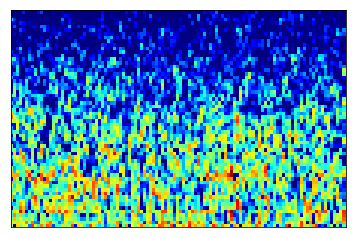

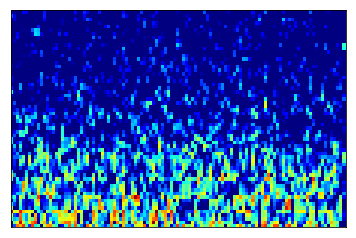

In [15]:
########## Przykład, z ptakiem i bez ptaka
for i in (2,np.shape(rep1)[0] - 5 ):  
  #print(rep3.iloc[i]) 
  librosa.display.specshow(rep3[i], cmap="jet", sr=44100)
  plt.show()

['rep1', 'rep2', 'rep3', 'rep4', 'rep5', 'rep6', 'rep7', 'final_description', 'nobirds_chunks']
(66, 60, 111)
[   4362 1526700 1527200       0       0       0       0       0       0
       0]
[ 854 4611 3574 3427 2913 2556 2998 1313  751 3938 4109 2647 1864 1354
 4327 3809 4594 3401  451 4362 1134  466  668  736 3686 3601 1279 4122
 4720 4590 4462 2643  145 3821 1719 5010 3413 4824 2104 1232 4680 2293
  984  985 4540  191 2044 3507 4038 4016]


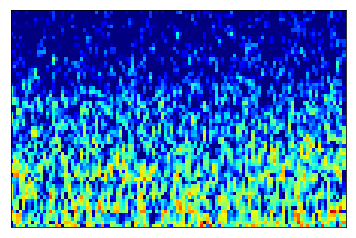

In [16]:
########## Przykład jak ładować dane
nazwa_out = '_7rep'
#dane1 = np.load(source_out + nazwa + 'balanced_dataset.npy')
dane1 = np.load(source_out + nazwa + nazwa_out + '.npz' )
#fre = opisy1['freqs']
#print(opisy1.files)
#print(fre)

r3 = dane1['rep3']
des = dane1['final_description']
print(dane1.files)
print(np.shape(dane1["rep3"]))
k = 35 # nr próbki
print(des[k])
librosa.display.specshow(r3[k], cmap="jet", sr=44100)

print(dane1['nobirds_chunks'])

In [17]:
print(dane1['final_description'])

[[     80   28000   28500   28246   28426   28246   28426       1       0
        0]
 [     81   28350   28850   28350   28426   28246   28426       1       0
        0]
 [    158   55300   55800   55736   55800   55736   56159       1       0
        0]
 [    159   55650   56150   55736   56150   55736   56159       1       0
        0]
 [    160   56000   56500   56000   56159   55736   56159       1       0
        0]
 [    327  114450  114950  114769  114782  114769  114782       1       0
        0]
 [    689  241150  241650  241437  241503  241437  241503       1       0
        0]
 [    719  251650  252150  252084  252098  252084  252098       1       0
        0]
 [    720  252000  252500  252084  252098  252084  252098       1       0
        0]
 [    997  348950  349450  349440  349450  349440  349450       1       0
        0]
 [    998  349300  349800  349440  349450  349440  349450       1       0
        0]
 [   1014  354900  355400  355152  355159  355152  355159       1